## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI3D-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'dad'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
dad_wavelet_full_syntheticMRI3D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

SAVE_FIGS = True
plots_path = os.path.join(ROOT_DIR, "publication", "poster", "plots")
GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False

CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\syntheticMRI3D\\full\\wavelet\\dad'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
# if 'fourier' in TRANSFORM:
#     GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
# elif 'wavelet' in TRANSFORM:
#     GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
# GROUPS=[8]

In [6]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [7]:
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = 0)

## Comparing Empirical and Computed CDF/PDF

In [8]:
FONT_SIZE = 35

plt.rcParams.update({'font.size': FONT_SIZE})
plt.rcParams.update({'legend.fontsize': FONT_SIZE, 'legend.markerscale': 3.0})


In [9]:
group = 8
group_info = master_df.loc[group]
best_r = group_info['best_r']
best_eta = group_info['best_eta']
best_scale = group_info['best_scale']
sample = group_data_map[group]
params = (best_r, best_eta, best_scale) 
log_scale = True
group = group
distro = 'gengamma'
log_scale = True
n_samples=2000
interval = None
provided_loc = None
group=None, 
percent_excluded=0.1
plot_hist=True
bw = 0.05
bw_log = 0.05
binwidth = None

Params: 0.08, 2.1
Chebyshev bound: 236.2910288550611
Tail samples: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.023221372041578203
First CDF value: 1.4269719741835093e-06
Last CDF value: 0.9999985730280259
Tail bound: 0.001
5.42


C:\Users\yashd\AppData\Local\Temp\ipykernel_34572\3251400316.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend().set_visible(False)
C:\Users\yashd\AppData\Local\Temp\ipykernel_34572\3251400316.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend().set_visible(False)


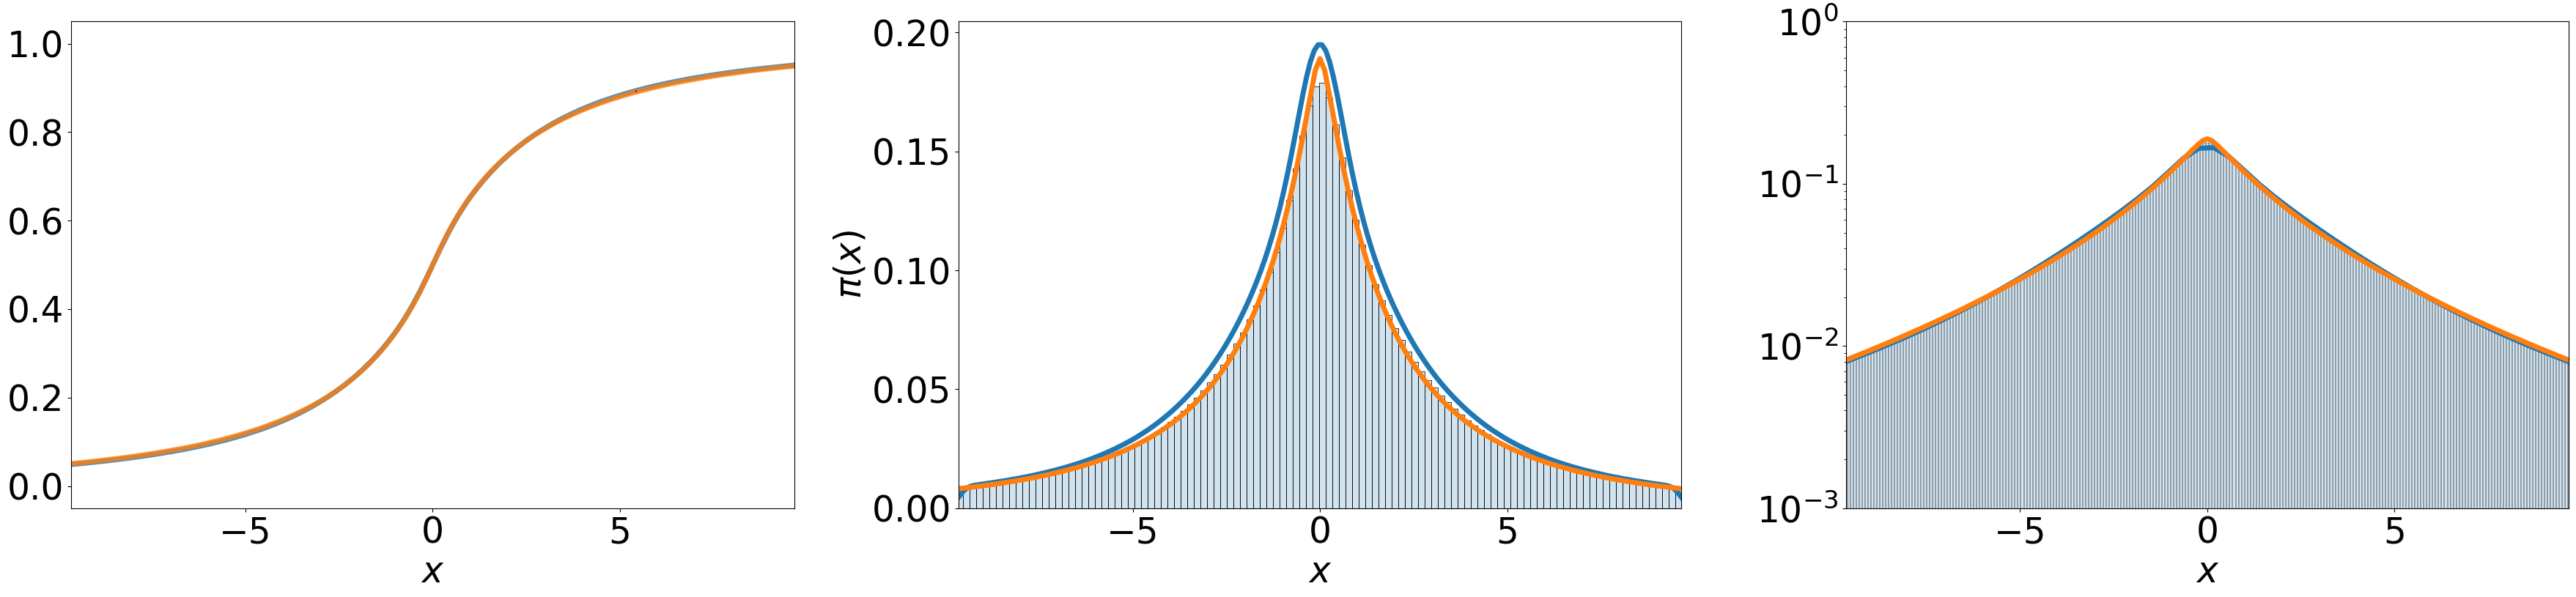

In [19]:
if len(sample) > 0:
    lower_bound = np.percentile(sample, percent_excluded/2)
    upper_bound = np.percentile(sample, (100-percent_excluded/2))
    original_sample = sample
    sample = sample[(sample > lower_bound) & (sample < upper_bound)]
    sample = np.sort(sample)
    n = len(sample)
    if interval is None:
        interval = (np.percentile(sample, 5), np.percentile(sample, 95))
    xs = np.linspace(max(interval[0], np.min(sample)), min(np.max(sample), interval[1]), 2000000)

if distro == 'gengamma':
    if len(params) == 3:
        r, eta, scale = params
    else:
        r, eta = params
        scale = 1
    xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, scale = scale, n_samples=n_samples, enforce_assert=False, debug=True, return_xs=True)
    null_pdf = null_cdf.derivative()(xs_pdf)
    
elif distro == 'gaussian' or distro == 'normal':
    null_cdf = stats.norm(scale=params).cdf
    xs_pdf = np.linspace(-30, 30, 10000)
    null_pdf = stats.norm(scale=params).pdf(xs)
elif distro == 'laplace':
    null_cdf = stats.laplace(scale=params).cdf
    xs_pdf = np.linspace(-30, 30, 10000)
    null_pdf = stats.laplace(scale=params).pdf(xs_pdf)

if log_scale:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36, 9), sharex=True)
    # fig.suptitle(f'{f"{GROUP_NAME} {group}" if group else ""} Empirical CDF vs Computed CDF \n (r={r}, eta={eta}, scale={np.format_float_scientific(scale, 2)})', fontsize=fontsize)
    if interval:
        ax1.set_xlim(left = interval[0], right = interval[1])

    if len(sample) > 0:
        ax1.plot(sample, np.arange(1, n+1)/n, label='Empirical CDF', linewidth=5, alpha=0.8)
        result = stats.ks_1samp(original_sample, null_cdf)
        distance = result.statistic
        location = result.statistic_location
        emp_cdf_at_loc = np.searchsorted(original_sample, location, side='right') / n
        computed_cdf_at_loc = null_cdf(location)
        ax1.plot(xs, null_cdf(xs), label='Computed CDF', linewidth=5, alpha=0.8)
        location = np.round(location, 2)
        print(location)
        ax1.vlines(location, emp_cdf_at_loc, computed_cdf_at_loc, linestyles='--', color='xkcd:bright red', label=f'KS Stat: {np.round(distance, 4)} at x={5.35}')
    else:
        ax1.plot(xs_pdf, null_cdf(xs_pdf))

    if len(sample) > 0 and provided_loc:
        emp_cdf_at_provided_loc = np.searchsorted(original_sample, provided_loc, side='right') / n
        computed_cdf_at_provided_loc = null_cdf(provided_loc)
        ax1.vlines(provided_loc, emp_cdf_at_provided_loc, computed_cdf_at_provided_loc, linestyles='--', color='xkcd:shamrock green')

    if interval:
        ax2.set_xlim(left = interval[0], right = interval[1])
    
    if len(sample)>0:
        sns.kdeplot(sample[(sample >= interval[0]) & (sample <= interval[1])], bw_method = bw, ax=ax2, linewidth=5)
        if plot_hist:
            sns.histplot(sample, ax=ax2, binwidth = binwidth, stat='density', alpha=0.2)
    ax2.plot(xs_pdf, null_pdf, linewidth=5)
    
    if interval:
        ax3.set_xlim(left = interval[0], right = interval[1])
    ax3.set_ylim(bottom = 10**-4, top=10)
    
    if len(sample)>0:
        sns.kdeplot(ax = ax3, x = sample, bw_method = bw_log, log_scale=[False, True], linewidth=5)
        if plot_hist:
            sns.histplot(sample, ax = ax3, binwidth = binwidth, stat = "density", log=True, bins=1000, alpha=0.2, color='#1f77b4', line_kws={'linewidth': 5})

    ax3.plot(xs_pdf, null_pdf, linewidth=5)
    
    if len(sample) == 0:
        ax1.set_title(f'Visualized {distro} CDF with params {params}')
        ax2.set_title(f'Visualized {distro} PDF with params {params}')
        ax3.set_title(f'Visualized {distro} PDF (log-scale) with params {params}')
    # elif distro == 'gengamma':
    #     ax1.set_title(f'Empirical vs Computed CDF', pad=10)
    #     ax2.set_title(f'Empirical vs Computed PDF', pad=10)
    #     ax3.set_title(f'Log Scale: Empirical vs Computed PDF', pad=10)

    ax1.set_ylabel("")
    ax2.set_ylabel(r"$\pi(x)$")
    ax3.set_ylabel("")
    
    ax1.set_xlabel(r"$x$")
    ax2.set_xlabel(r"$x$")
    ax3.set_xlabel(r"$x$")

    # Set tick font size
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
        ax.tick_params(axis='both', which='minor', labelsize=FONT_SIZE)

    # Hide legends
    ax1.legend().set_visible(False)
    ax2.legend().set_visible(False)
    ax3.legend().set_visible(False)

    ax3.set_ylim((1e-3, 1))

    plt.tight_layout()
    plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "cdf_pdf_plot.jpg"), dpi=1000)

In [11]:
handles, labels = ax1.get_legend_handles_labels()
handles, labels

([<matplotlib.lines.Line2D at 0x21d9d12c3d0>,
 ['Empirical CDF', 'Computed CDF', 'KS Stat: 0.0019 at x=5.35'])

C:\Users\yashd\AppData\Local\Temp\ipykernel_34572\3861266800.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


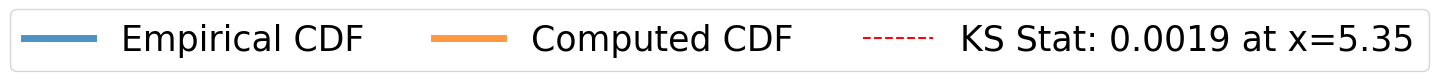

In [16]:
legend_fig = plt.figure(figsize=(8, 0.5))
legend_ax = legend_fig.add_subplot(111)
legend_ax.axis('off')  # Turn off the axis

legend_fig.legend(handles=handles, labels=labels, loc='center', ncol=6, fontsize=25)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    legend_save_path = os.path.join(plots_path, "cdf_pdf_legend.jpg")
    legend_fig.savefig(legend_save_path, dpi=600, bbox_inches='tight')